# Similarité de compétences techniques

Objectif: Construire une métrique de similarité entre compétences techniques à partir de profils d'employés

Exercices:
1. Exploration et visualisation de la donnée
2. Trouver les 10 compétences les plus pertinentes à un métier. Par exemple: 'analyste de risques'
3. Trouver les 10 compétences les plus similaires à une autre compétence. Par exemple: 'Python'
4. Trouver le métier qui a le plus de compétences en commun avec un autre métier. Par exemple 'responsable de projet'

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_skills = pd.read_csv('employee_skills.csv') #get skills per profile
df_profiles = pd.read_csv('employee_profiles.csv') #get job title per profile

In [3]:
df_profiles.head()

,id_profile,jobtitle
0,918318,responsable de projet
1,835172,webmaster
2,814422,développeur
3,503545,responsable de projet
4,49282,responsable de projet


In [4]:
df_skills.head()

,id_profile,skill
0,918318,Consulting
1,918318,Management
2,918318,Project Management
3,918318,Change Management
4,918318,Marketing


### Preprocessing

In [5]:
def normalize_punkt(text: str) -> str:
    """Normalize punktuation"""
    punkt = ["!","$", "%", ",", ":", ";", "?", "[", "]", "|"]
    for p in punkt:
        text = text.replace(p, ' '+p+' ')
    return text.strip()


def cleaning_punktuation(text: str) -> str:
    """Prepares text for keywords extractions."""

    to_clean = normalize_punkt(text) #Adding space between some punktuations
    to_clean = to_clean.replace('\n', ' ') # when job_title finishes in next line
    to_clean = re.sub('\s+', ' ', to_clean) # replacing all spaces caracters by one
    to_clean = to_clean.replace(',', ' , ')

    # Case where there is '.' in text:
    if '.' in to_clean:
        if re.findall(r'\D[0-9]+\.[\S]',
                      to_clean) != []:  # On nettoye les cas avec des versions de framework dans les keywords uniquement
            to_clean = re.sub(r'\D[0-9]+\.[\S]', '', to_clean)
        if ' . ' in to_clean:
            to_clean = to_clean.replace(' . ', '')
        elif to_clean.endswith('.'):
            to_clean = to_clean[:-1]

    # Case where there is '-' in text
    if '-' in to_clean:
        if re.findall('\w+-\w+', to_clean) != []:
            compound_words = re.findall('\w{4,}-\w{4,}', to_clean)
            for cw in compound_words:
                to_clean = to_clean.replace(cw,
                                            cw.replace('-', ' '))  # Avoid cleaning tech words like ('e-commerce', '')
        else:
            to_clean = to_clean.replace('-', ' ')

    # Plus/hashtag sign cleaned only if it's surrounded by spaces
    to_clean = to_clean.replace(' + ', ' ').replace(' # ', ' ').replace('_', ' ')

    # Replacing apostrophe '’' by '''
    to_clean = re.sub(" *' *", "'", to_clean.replace('’', "'"))

    # Replacing articles with apostrophes
    to_clean = re.sub("d'", "", to_clean)
    to_clean = re.sub("l'", "", to_clean)

    # Replacing /() by spaces
    to_clean = to_clean.replace('/', ' ').replace('(', ' ').replace(')', ' ').replace('* ', '').replace('- ', '').replace(':', '')

    # Case where there is '&' in text
    to_clean = to_clean.replace(' & ', ' et ')

    # cleaning isolated numbers
    to_clean = re.sub(' [0-9] ', '', to_clean)

    cleaned = re.sub('\s+', ' ', to_clean.strip())

    return cleaned.lower()



In [6]:
df_skills['skill'] = df_skills['skill'].apply(lambda x: cleaning_punktuation(x))

### Get a dataframe per job title

Since we are interested in getting the most significant technical skills for each job title (e.g. what skills charecterize the most "Responsable de projet" in our dataset), we split our data in several dataframes based on the job titles.

In [7]:
df_profiles['jobtitle'].value_counts() #we get 5 types of job titles

responsable de projet    4427
analyste de risques      4151
webmaster                3360
ingénieur r&d            3331
développeur              3253
Name: jobtitle, dtype: int64

In [8]:
def get_df_job(job_name):
    """
    Get a dataframe of skills containing only the rows of the skills
    related  to a specific job
    
    """
    df_new = df_profiles.loc[df_profiles['jobtitle']== job_name]
    df_skills_new = df_skills.loc[df_skills['id_profile'].isin(df_new['id_profile'])]
    
    return df_skills_new

In [9]:
# get df containing skills for each job title
df_skills_responsable_projet = get_df_job('responsable de projet')
df_skills_analyste_de_risques = get_df_job('analyste de risques')
df_skills_webmaster = get_df_job('webmaster')
df_skills_ingénieur_rd = get_df_job('ingénieur r&d')
df_skills_developpeur = get_df_job('développeur')

### TF-IDF
We are using TF-IDF (term frequency - inversed document frequency) to:
- get the most significant skills for each job title based on the scores per skill
- map words into an n-dimensional vector space to be able to get the most similar skills

In [10]:
def identity_tokenizer(text):
    """
    Function allowing to pass a list of words to sklearn vectorizer
    """
    return text


def get_tfidf_results(df):
    """
    Get vectors using tfidf
    
    :param df: dataframe containing either skills for a specific job
    :return: tfidf object, X - matrix with a row per profile and column per word, 
    res_df - dataframe with a row per profile and column per word
    """
    
    #list of lists of skills
    list_profile_skills = [] 
    
    # grouped skills per profile
    temp_df = df.groupby(by="id_profile", dropna=False)['skill']

    
    for profile in temp_df:
        list_profile_skills.append(profile[1].tolist())

    tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, max_features = 5000)

    tfidf.fit(list_profile_skills) 
    X = tfidf.transform(list_profile_skills).toarray()  
    res_df = pd.DataFrame(X, columns=tfidf.vocabulary_)

    return tfidf, X, res_df
    

def get_top_n_skills(n, df_job_title, job_title):
    """
    Get n most significant skills for a specific job title
    
    :param n: number of most significant skills to return
    :param df_job_title: dataframe with the skills for a specific job title
    :param job_title: str name of the job title of interest
    
    """
    
    tfidf, X, df_res =  get_tfidf_results(df_job_title) 
    
    feature_array = np.array(tfidf.get_feature_names())
    tfidf_sorting = np.argsort(X).flatten()[::-1]
    
    top_n = feature_array[tfidf_sorting][:n]
    
    print(f'The most significant skills for {job_title.upper()}:\n')
    print(*top_n, sep = "\n")


In [11]:
get_top_n_skills(10, df_skills_analyste_de_risques, 'analyste de risques') # put any job title of interest

The most significant skills for ANALYSTE DE RISQUES:

heat exchangers
innovation technologique
management fonctionnel
energy management
processus achat
gestion des fournisseurs
droit des marchés publics
gestion des achats
génie civil
project engineering


### Results of most significant skills

TF-IDF is proved to be useful for the tasks dependent on the lexical level features. From the results we can see that the most significant skills make sense for a specific job title. This method is very sensitive to the noisy input data. The highest TF-IDF score may not make sense with the topic of the profile skills, since IDF gives high weight if the DF of a term is low.

Other possible approaches:
- LDA topic modeling

In [12]:
def get_similar_skills(skill, n):      
    """
    Given a skill get n most similar skills
    
    :param skill: a string of a skill for which we find the closest skill
    :param n: number of closest skills to return
    
    :return: dict of closest skills and their cosine similarity scores
    """
    tfidf, X, df =  get_tfidf_results(df_skills) # 
    
    list_score = []
    for c in df.columns:
        if c!=skill:
            tup = ( 1 - cosine(df[skill], df[c]), c) #compare skills from the tfidf dataframe
            list_score.append(tup)
            
    close_skills = sorted(list_score, reverse = True)[:n]
    score_list, skill_list = zip(*close_skills) 
    
    plt.bar(skill_list, score_list, color = '#C76EFF')
    plt.xticks(rotation=90)
    plt.show()
    
    return close_skills

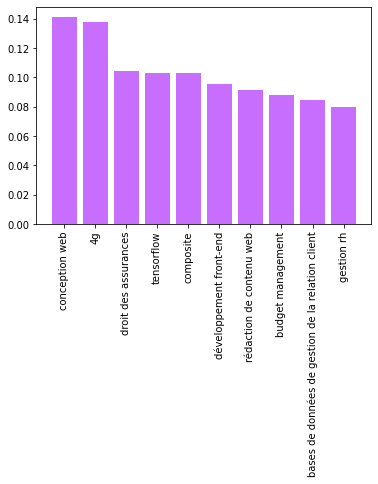

In [13]:
list_score_skill = get_similar_skills("python", 10)

### Jaccard

In [14]:
def get_skill_ids(df):
    """
    Get a dict with skills as keys and list of profile ids as values
    
    :param df: skills dataframe for a specific job 
    :return: dict with skill as key and job ids as value
    """
    dic_profile_skills = {}
    temp = df.groupby(by = 'skill')['id_profile']#grouped df by skill to get ids

    for profile in temp:
        dic_profile_skills[profile[0]] = profile[1].tolist()
        
    return dic_profile_skills

def jaccard_set(list1, list2):
    """Jaccard Similarity function for two sets"""
    
    intersection = len((set(list1).intersection(list2)))
    union = len(set(list1).union(set(list2)))
    return float(intersection) / union

def get_similar_skill_jaccard(df_job, skill, n):
    """
    Given a skill get the closest skill based on the jaccard scores
    :param dic_profile_skill: dict where key is skill and value is list of ids of profiles
    :param skill: skill name for which we want to find the closest skills
    :param n: number of the closest skills 
    :return: dict of the closest skills
    """
    dic_skill_score = {}
    
    dic_profile_skills = get_skill_ids(df_job)
    list_ids_skill = dic_profile_skills[skill]
    
    for skill_compare, ids_compare in dic_profile_skills.items():
        if skill!= skill_compare:
            dic_skill_score[skill_compare] =jaccard_set(list_ids_skill, ids_compare)
    
    close_skills = sorted(dic_skill_score.items(), key=lambda kv: kv[1], reverse= True)[:n]
    
    score_list = [x[0] for x in close_skills]
    skill_list = [x[1] for x in close_skills]
    
    
    plt.bar(score_list, skill_list, color = '#C76EFF')
    plt.xticks(rotation=90)
    plt.show()
    return close_skills

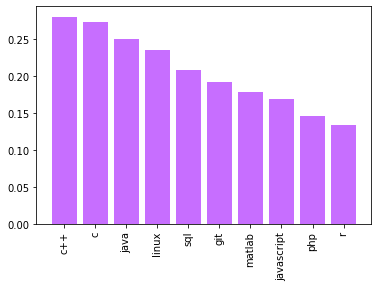

[('c++', 0.28054118583366494),
 ('c', 0.2740619902120718),
 ('java', 0.25055785782594836),
 ('linux', 0.23586671658554847),
 ('sql', 0.20915411355735805),
 ('git', 0.19229397074562968),
 ('matlab', 0.17863247863247864),
 ('javascript', 0.169872595553335),
 ('php', 0.14632814632814634),
 ('r', 0.1335816923895689)]

In [15]:
 get_similar_skill_jaccard(df_skills, "python", 10)

### Results of similar results
Comparing TF-IDF and Jaccard scoring methods, we can see that created vectors using TF-IDF yield the most similar skills that make less sense than those that were created by Jaccard scoring. This might be due to the fact that IDF gives high weight if the DF of a term is low.

Other possible approcahes:
- get word2vec for each skill and calculate cosine similarity

In [16]:
list_df_jobs = [
    ('responsable de projet',df_skills_responsable_projet),\
    ('analyste de risque',df_skills_analyste_de_risques),\
    ('webmaster',df_skills_webmaster), \
    ('ingénieur r&d',df_skills_ingénieur_rd),\
    ('développeur',df_skills_developpeur)
    ]

In [17]:
def get_closest_job_title(df_job_title, job_title):
    """
    Given dataframe of the job find the closest job
    
    :param df_job_title: dataframe of job in interest
    :param job_title: str name of the job in interest
    :return: sorted dict with jaccard scores of skills
    """
    dic_scores = {}
    set_skills_job_title = set(df_job_title['skill'].tolist())
    
    for tup in list_df_jobs:
        job_name, df = tup
        if str(df)!= str(df_job_title):
            dic_scores[job_name] = jaccard_set(set_skills_job_title,\
             set(df['skill'].tolist()))
    
    sorted_dic = sorted(dic_scores.items(), key=lambda kv: kv[1], reverse = True)
    print(f'Most similar job title to {job_title.upper()} is {sorted_dic[0][0].upper()}')
    return sorted_dic
            

In [18]:
get_closest_job_title(df_skills_responsable_projet, 'responsable de projet')

Most similar job title to RESPONSABLE DE PROJET is WEBMASTER


[('webmaster', 0.2539832483153851),
 ('analyste de risque', 0.23500725689404936),
 ('développeur', 0.2031205061834915),
 ('ingénieur r&d', 0.19014719134875338)]

In [19]:
get_closest_job_title(df_skills_analyste_de_risques, 'analyste de risques')

Most similar job title to ANALYSTE DE RISQUES is RESPONSABLE DE PROJET


[('responsable de projet', 0.23500725689404936),
 ('webmaster', 0.20307348092322186),
 ('ingénieur r&d', 0.17942916811695092),
 ('développeur', 0.1652596744782873)]